# Mental Health Risk Detection – Data Exploration

This notebook explores and analyzes the datasets used for training the DistilBERT risk classification model.

Datasets Used:
- mental_health.csv
- Suicide_Detection.csv

Objective:
- Standardize labels
- Analyze class distribution
- Inspect text length variation
- Prepare data understanding before model training


In [2]:
import pandas as pd

# Load datasets
df_old = pd.read_csv("../data/raw/mental_health.csv")
df_new = pd.read_csv("../data/raw/Suicide_Detection.csv")

print("Old Dataset Shape:", df_old.shape)
print("New Dataset Shape:", df_new.shape)

print("\nOld Dataset Preview:")
display(df_old.head())

print("\nNew Dataset Preview:")
display(df_new.head())


Old Dataset Shape: (53043, 3)
New Dataset Shape: (232074, 3)

Old Dataset Preview:


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety



New Dataset Preview:


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
# Standardize column names
df_old = df_old.rename(columns={'statement': 'text', 'status': 'risk_label'})

old_mapping = {
    'Suicidal': 'High',
    'Depression': 'Moderate',
    'Anxiety': 'Moderate',
    'Stress': 'Moderate',
    'Bi-Polar': 'Moderate',
    'Personality Disorder': 'Moderate',
    'Normal': 'Low'
}

df_old['risk_label'] = df_old['risk_label'].map(old_mapping)
df_old = df_old[['text', 'risk_label']]

df_new = df_new.rename(columns={'class': 'risk_label'})
df_new['risk_label'] = df_new['risk_label'].map({
    'suicide': 'High',
    'non-suicide': 'Low'
})
df_new = df_new[['text', 'risk_label']]

print("Old Dataset Label Distribution:")
print(df_old['risk_label'].value_counts())

print("\nNew Dataset Label Distribution:")
print(df_new['risk_label'].value_counts())


Old Dataset Label Distribution:
risk_label
Moderate    21961
Low         16351
High        10653
Name: count, dtype: int64

New Dataset Label Distribution:
risk_label
High    116037
Low     116037
Name: count, dtype: int64


In [4]:
# Combine datasets
combined_df = pd.concat([df_old, df_new], ignore_index=True).dropna()

print("Combined Dataset Shape:", combined_df.shape)

print("\nFinal Label Distribution:")
print(combined_df['risk_label'].value_counts())


Combined Dataset Shape: (280901, 2)

Final Label Distribution:
risk_label
Low         132380
High        126689
Moderate     21832
Name: count, dtype: int64


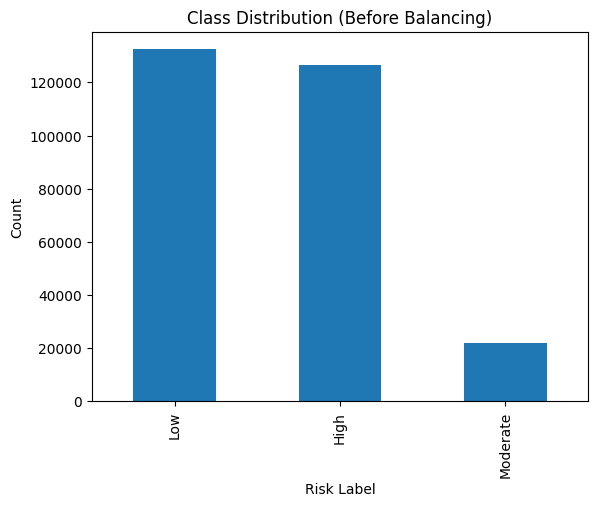

In [5]:
import matplotlib.pyplot as plt

combined_df['risk_label'].value_counts().plot(
    kind='bar',
    title='Class Distribution (Before Balancing)'
)

plt.xlabel("Risk Label")
plt.ylabel("Count")
plt.show()


## Class Imbalance Observation

The dataset shows imbalance:

- Low and High risk classes dominate the dataset.
- Moderate class is significantly smaller.

To prevent model bias toward majority classes, balanced sampling was applied during training.


In [6]:
# Simulate balancing strategy used in training

df_low = combined_df[combined_df['risk_label'] == 'Low'].sample(n=15000, random_state=42)
df_high = combined_df[combined_df['risk_label'] == 'High'].sample(n=15000, random_state=42)
df_mod = combined_df[combined_df['risk_label'] == 'Moderate']

balanced_df = pd.concat([df_low, df_mod, df_high])

print("Balanced Dataset Distribution:")
print(balanced_df['risk_label'].value_counts())


Balanced Dataset Distribution:
risk_label
Moderate    21832
Low         15000
High        15000
Name: count, dtype: int64


## Tokenization & Model Preparation (DistilBERT)

The balanced dataset is tokenized using the DistilBERT tokenizer.
This converts text into numerical representations suitable for Transformer-based classification.

Training is performed using:
- DistilBERT (distilbert-base-uncased)
- Sequence classification head
- 3 output classes (Low, Moderate, High)
- Mixed precision (FP16) for GPU efficiency
